In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import and view data
heart_rate_url = 'https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/heart_rate.csv'
sleep_url = 'https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/sleep.csv'
calories_url = 'https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/calories.csv'
steps_url = 'https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/steps.csv'
daily_intensities_url = "https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/daily_intensities.csv"
hourly_intensities_url = "https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/hourly_intensities.csv"
minute_intensities_url = "https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/minute_intensities_narrow.csv"
weight_log_url = "https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/weight_log.csv"
minute_sleep_url = "https://raw.githubusercontent.com/bellafrid/ec_utb/refs/heads/main/health_analysis/minute_sleep.csv"

heart_rate_df = pd.read_csv(heart_rate_url)
sleep_df = pd.read_csv(sleep_url)
calories_df = pd.read_csv(calories_url)
steps_df = pd.read_csv(steps_url)
daily_int_df = pd.read_csv(daily_intensities_url)
hourly_int_df = pd.read_csv(hourly_intensities_url)
minute_int_df = pd.read_csv(minute_intensities_url)
weight_log_df = pd.read_csv(weight_log_url)
minute_sleep_df = pd.read_csv(minute_sleep_url)

print(heart_rate_df.head())
print(sleep_df.head())
print(calories_df.head())
print(steps_df.head())
print(daily_int_df.head())
print(hourly_int_df.head())
print(minute_int_df.head())
print(weight_log_df.head())
print(minute_sleep_df.head())

           Id                  Time  Value
0  2022484408  4/12/2016 7:21:00 AM     97
1  2022484408  4/12/2016 7:21:05 AM    102
2  2022484408  4/12/2016 7:21:10 AM    105
3  2022484408  4/12/2016 7:21:20 AM    103
4  2022484408  4/12/2016 7:21:25 AM    101
           Id               SleepDay  TotalSleepRecords  TotalMinutesAsleep  \
0  1503960366  4/12/2016 12:00:00 AM                  1                 327   
1  1503960366  4/13/2016 12:00:00 AM                  2                 384   
2  1503960366  4/15/2016 12:00:00 AM                  1                 412   
3  1503960366  4/16/2016 12:00:00 AM                  2                 340   
4  1503960366  4/17/2016 12:00:00 AM                  1                 700   

   TotalTimeInBed  
0             346  
1             407  
2             442  
3             367  
4             712  
           Id ActivityDay  Calories
0  1503960366   4/12/2016      1985
1  1503960366   4/13/2016      1797
2  1503960366   4/14/2016      1776
3  

In [10]:
# Check for missing values
print(heart_rate_df.isnull().sum())
print(sleep_df.isnull().sum())
print(calories_df.isnull().sum())
print(steps_df.isnull().sum())
print(daily_int_df.isnull().sum())
print(hourly_int_df.isnull().sum())
print(minute_int_df.isnull().sum())
print(weight_log_df.isnull().sum())
print(minute_sleep_df.isnull().sum())

Id       0
Time     0
Value    0
dtype: int64
Id                    0
SleepDay              0
TotalSleepRecords     0
TotalMinutesAsleep    0
TotalTimeInBed        0
dtype: int64
Id             0
ActivityDay    0
Calories       0
dtype: int64
Id             0
ActivityDay    0
StepTotal      0
dtype: int64
Id                          0
ActivityDay                 0
SedentaryMinutes            0
LightlyActiveMinutes        0
FairlyActiveMinutes         0
VeryActiveMinutes           0
SedentaryActiveDistance     0
LightActiveDistance         0
ModeratelyActiveDistance    0
VeryActiveDistance          0
dtype: int64
Id                  0
ActivityHour        0
TotalIntensity      0
AverageIntensity    0
dtype: int64
Id                0
ActivityMinute    0
Intensity         0
dtype: int64
Id                 0
Date               0
WeightKg           0
WeightPounds       0
Fat               65
BMI                0
IsManualReport     0
LogId              0
dtype: int64
Id       0
date     0
val

In [11]:
# Converting time and date
def convert_date(date_str, df_name, col_name):
    formats = [
        '%m/%d/%Y %I:%M:%S %p',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d',
        '%m/%d/%Y',
        '%d/%m/%Y',
    ]

    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue

    print(f"Warning: '{date_str}' in DataFrame '{df_name}', column '{col_name}' couldn't convert.")
    return pd.NaT

def process_dataframe(df, date_columns, df_name):
    for col in date_columns:
        df[col] = df[col].apply(lambda x: convert_date(x, df_name, col))

        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df['date'] = df[col].dt.strftime('%y%m%d')  # YYMMDD format
            df['time'] = df[col].dt.strftime('%H:%M:%S')  # 24-timmars format
        else:
            print(f"Problem: Column '{col}' in DataFrame '{df_name}' couldn't convert to datetime.")

    return df

dataframes = {
    'heart_rate_df': (heart_rate_df, ['Time']),
    'sleep_df': (sleep_df, ['SleepDay']),
    'calories_df': (calories_df, ['ActivityDay']),
    'steps_df': (steps_df, ['ActivityDay']),
    'daily_int_df': (daily_int_df, ['ActivityDay']),
    'hourly_int_df': (hourly_int_df, ['ActivityHour']),
    'minute_int_df': (minute_int_df, ['ActivityMinute']),
    'weight_log_df': (weight_log_df, ['Date']),
}

for name, (df, cols) in dataframes.items():
    print(f"\nProcessing DataFrame: {name}")
    dataframes[name] = (process_dataframe(df, cols, name), cols)

heart_rate_df, heart_rate_cols = dataframes['heart_rate_df']
sleep_df, sleep_cols = dataframes['sleep_df']
calories_df, calories_cols = dataframes['calories_df']
steps_df, steps_cols = dataframes['steps_df']
daily_int_df, daily_int_cols = dataframes['daily_int_df']
hourly_int_df, hourly_int_cols = dataframes['hourly_int_df']
minute_int_df, minute_int_cols = dataframes['minute_int_df']
weight_log_df, weight_log_cols = dataframes['weight_log_df']

print(heart_rate_df.head())
print(sleep_df.head())
print(calories_df.head())
print(steps_df.head())
print(daily_int_df.head())
print(hourly_int_df.head())
print(minute_int_df.head())
print(weight_log_df.head())


Processing DataFrame: heart_rate_df

Processing DataFrame: sleep_df

Processing DataFrame: calories_df

Processing DataFrame: steps_df

Processing DataFrame: daily_int_df

Processing DataFrame: hourly_int_df

Processing DataFrame: minute_int_df

Processing DataFrame: weight_log_df
           Id                Time  Value    date      time
0  2022484408 2016-04-12 07:21:00     97  160412  07:21:00
1  2022484408 2016-04-12 07:21:05    102  160412  07:21:05
2  2022484408 2016-04-12 07:21:10    105  160412  07:21:10
3  2022484408 2016-04-12 07:21:20    103  160412  07:21:20
4  2022484408 2016-04-12 07:21:25    101  160412  07:21:25
           Id   SleepDay  TotalSleepRecords  TotalMinutesAsleep  \
0  1503960366 2016-04-12                  1                 327   
1  1503960366 2016-04-13                  2                 384   
2  1503960366 2016-04-15                  1                 412   
3  1503960366 2016-04-16                  2                 340   
4  1503960366 2016-04-17    

In [12]:
# Converting time and date for minute_sleep_df seperatly because of previous errors
def process_df(df, date_column, time_included=False):
    try:
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y %I:%M:%S %p', errors='raise')
    except Exception as e:
        print(f"Error with converting '{date_column}': {e}")
        return df

    original_count = len(df)
    df = df.dropna(subset=[date_column])
    dropped_count = original_count - len(df)
    print(f"Dropped {dropped_count} rows due to NaT values.")

    df['new_date'] = df[date_column].dt.strftime('%y%m%d')

    if time_included:
        df['time'] = df[date_column].dt.strftime('%H:%M:%S')

    return df.drop(columns=[date_column])

minute_sleep_df.name = 'minute_sleep_df'
minute_sleep_df = process_df(minute_sleep_df, 'date', time_included=True)

Dropped 0 rows due to NaT values.


In [13]:
minute_sleep_df = minute_sleep_df.rename(columns={'new_date': 'date'})
print(minute_sleep_df.head())

           Id  value        logId    date      time
0  1503960366      3  11380564589  160412  02:47:30
1  1503960366      2  11380564589  160412  02:48:30
2  1503960366      1  11380564589  160412  02:49:30
3  1503960366      1  11380564589  160412  02:50:30
4  1503960366      1  11380564589  160412  02:51:30


In [14]:
# Removing columns
weight_log_df = weight_log_df.drop(columns=['WeightPounds', 'Fat', 'Date', 'IsManualReport'])
heart_rate_df = heart_rate_df.drop(columns=['Time'])
sleep_df = sleep_df.drop(columns=['SleepDay'])
calories_df = calories_df.drop(columns=['ActivityDay'])
steps_df = steps_df.drop(columns=['ActivityDay'])
daily_int_df = daily_int_df.drop(columns=['ActivityDay'])
hourly_int_df = hourly_int_df.drop(columns=['ActivityHour'])
minute_int_df = minute_int_df.drop(columns=['ActivityMinute'])

In [15]:
# Adding a stress indicator
heart_rate_df['is_stress'] = heart_rate_df['Value'].apply(lambda x: 1 if x > 100 else 0)

In [16]:
print(heart_rate_df.head())
print(sleep_df.head())
print(calories_df.head())
print(steps_df.head())
print(daily_int_df.head())
print(hourly_int_df.head())
print(minute_int_df.head())
print(weight_log_df.head())
print(minute_sleep_df.head())

           Id  Value    date      time  is_stress
0  2022484408     97  160412  07:21:00          0
1  2022484408    102  160412  07:21:05          1
2  2022484408    105  160412  07:21:10          1
3  2022484408    103  160412  07:21:20          1
4  2022484408    101  160412  07:21:25          1
           Id  TotalSleepRecords  TotalMinutesAsleep  TotalTimeInBed    date  \
0  1503960366                  1                 327             346  160412   
1  1503960366                  2                 384             407  160413   
2  1503960366                  1                 412             442  160415   
3  1503960366                  2                 340             367  160416   
4  1503960366                  1                 700             712  160417   

       time  
0  00:00:00  
1  00:00:00  
2  00:00:00  
3  00:00:00  
4  00:00:00  
           Id  Calories    date      time
0  1503960366      1985  160412  00:00:00
1  1503960366      1797  160413  00:00:00
2  150396

In [17]:
# Merge data to a new dataframe
daily_heart_df = heart_rate_df.groupby(['Id', 'date']).agg({
    'Value': ['max', 'mean'],
    'is_stress': 'max'
}).reset_index()

daily_heart_df.columns = ['Id', 'date', 'MaxHeartRate', 'MeanHeartRate', 'is_stress']

daily_sleep_df = sleep_df.groupby(['Id', 'date']).agg({
    'TotalSleepRecords': 'sum',
    'TotalMinutesAsleep': lambda x: round(x.sum() / 60, 2),
    'TotalTimeInBed': lambda x: round(x.sum() / 60, 2)
}).reset_index()

daily_sleep_df.rename(columns={'TotalMinutesAsleep': 'TotalHoursAsleep', 'TotalTimeInBed': 'TotalHoursInBed'}, inplace=True)

daily_calories_df = calories_df.groupby(['Id', 'date'])['Calories'].sum().reset_index()

daily_steps_df = steps_df.groupby(['Id', 'date'])['StepTotal'].sum().reset_index()

daily_intensity_df = daily_int_df.groupby(['Id', 'date']).agg({
    'SedentaryMinutes': lambda x: round(x.sum() / 60, 2),
    'LightlyActiveMinutes': lambda x: round(x.sum() / 60, 2),
    'FairlyActiveMinutes': lambda x: round(x.sum() / 60, 2),
    'VeryActiveMinutes': lambda x: round(x.sum() / 60, 2),
    'SedentaryActiveDistance': 'sum',
    'LightActiveDistance': 'sum',
    'ModeratelyActiveDistance': 'sum',
    'VeryActiveDistance': 'sum'
}).reset_index()

daily_intensity_df.rename(columns={
    'SedentaryMinutes': 'SedentaryHours',
    'LightlyActiveMinutes': 'LightlyActiveHours',
    'FairlyActiveMinutes': 'FairlyActiveHours',
    'VeryActiveMinutes': 'VeryActiveHours'
}, inplace=True)

daily_hourly_int_df = (
    hourly_int_df.groupby(['Id', 'date'])
    .agg(MaxTotalIntensity=('TotalIntensity', 'max'),
         MeanTotalIntensity=('TotalIntensity', 'mean'),
         MaxAverageIntensity=('AverageIntensity', 'max'),
         MeanAverageIntensity=('AverageIntensity', 'mean'))
    .reset_index()
)

for df in [daily_heart_df, daily_sleep_df, daily_calories_df, daily_steps_df, daily_intensity_df, daily_hourly_int_df]:
    df['date'] = pd.to_datetime(df['date'], format="%y%m%d")

dfs = [daily_heart_df, daily_sleep_df, daily_calories_df, daily_steps_df, daily_intensity_df, daily_hourly_int_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Id', 'date'], how='outer'), dfs)

print("Merged DataFrame:")
print(merged_df.head())

merged_df.to_csv('/content/drive/MyDrive/merged_data.csv', index=False)


Merged DataFrame:
           Id       date  MaxHeartRate  MeanHeartRate  is_stress  \
0  1503960366 2016-04-12           NaN            NaN        NaN   
1  1503960366 2016-04-13           NaN            NaN        NaN   
2  1503960366 2016-04-14           NaN            NaN        NaN   
3  1503960366 2016-04-15           NaN            NaN        NaN   
4  1503960366 2016-04-16           NaN            NaN        NaN   

   TotalSleepRecords  TotalHoursAsleep  TotalHoursInBed  Calories  StepTotal  \
0                1.0              5.45             5.77      1985      13162   
1                2.0              6.40             6.78      1797      10735   
2                NaN               NaN              NaN      1776      10460   
3                1.0              6.87             7.37      1745       9762   
4                2.0              5.67             6.12      1863      12669   

   ...  FairlyActiveHours  VeryActiveHours  SedentaryActiveDistance  \
0  ...               

In [18]:
merged_df.dropna(inplace=True)

print(merged_df.head())

             Id       date  MaxHeartRate  MeanHeartRate  is_stress  \
190  2026352035 2016-04-17          80.0      68.656250        0.0   
198  2026352035 2016-04-25         125.0      99.505814        1.0   
205  2026352035 2016-05-02         122.0      84.134571        1.0   
212  2026352035 2016-05-09         123.0      98.233901        1.0   
248  2347167796 2016-04-13         158.0      73.812905        1.0   

     TotalSleepRecords  TotalHoursAsleep  TotalHoursInBed  Calories  \
190                1.0              7.28             8.30      1214   
198                1.0              8.43             8.85      1576   
205                1.0              8.52             9.05      1690   
212                1.0              8.85             9.27      1869   
248                1.0              7.78             8.85      2038   

     StepTotal  ...  FairlyActiveHours  VeryActiveHours  \
190        838  ...               0.00             0.00   
198       6017  ...               

In [13]:
unique_id = merged_df['Id'].nunique()
print(f"Unique ID left: {unique_id}")

# Count unique ID
unique_date = merged_df['date'].nunique()
print(f"Unique dates left: {unique_date}")

Unique ID left: 12
Unique dates left: 31


<ipython-input-14-a4ac23834acf>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_int_df_grouped, x='hour', y='TotalIntensity', palette='coolwarm')


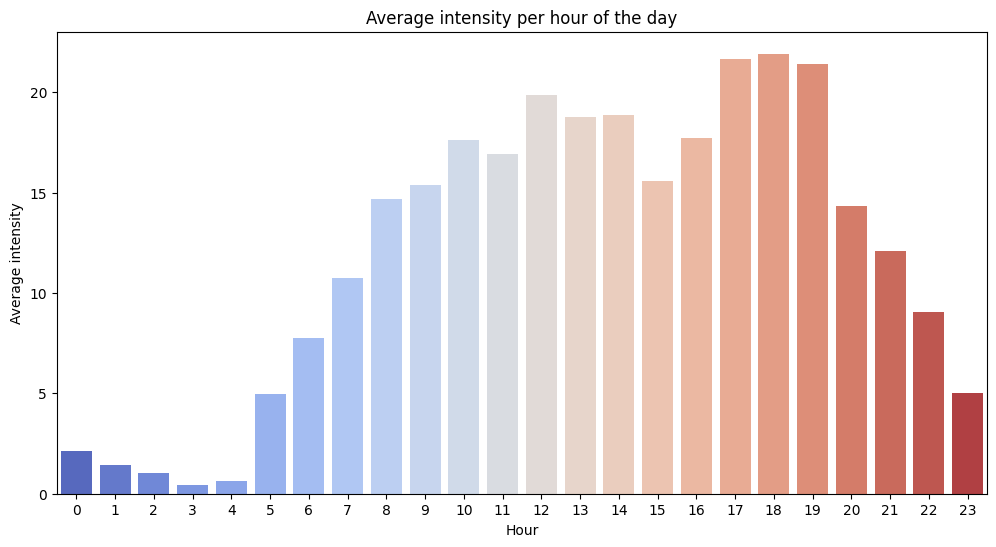

In [14]:
# Hourly intensity
hourly_int_df['time'] = pd.to_datetime(hourly_int_df['time'], format='%H:%M:%S')

hourly_int_df['hour'] = hourly_int_df['time'].dt.hour

hourly_int_df_grouped = hourly_int_df.groupby('hour')['TotalIntensity'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_int_df_grouped, x='hour', y='TotalIntensity', palette='coolwarm')
plt.title('Average intensity per hour of the day')
plt.xlabel('Hour')
plt.ylabel('Average intensity')
plt.show()

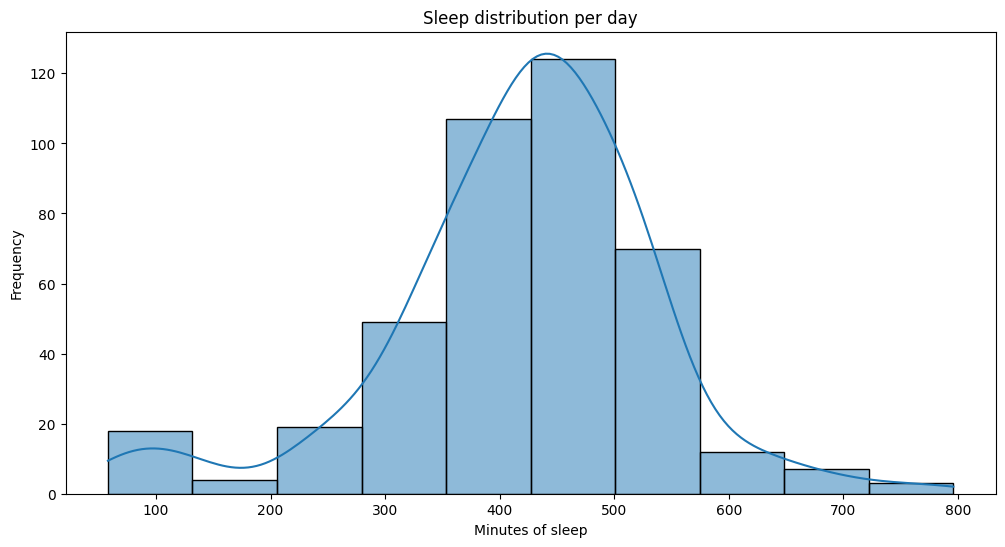

In [15]:
# Sleep per day
plt.figure(figsize=(12, 6))
sns.histplot(data=sleep_df, x='TotalMinutesAsleep', bins=10, kde=True)
plt.title('Sleep distribution per day')
plt.xlabel('Minutes of sleep')
plt.ylabel('Frequency')
plt.show()

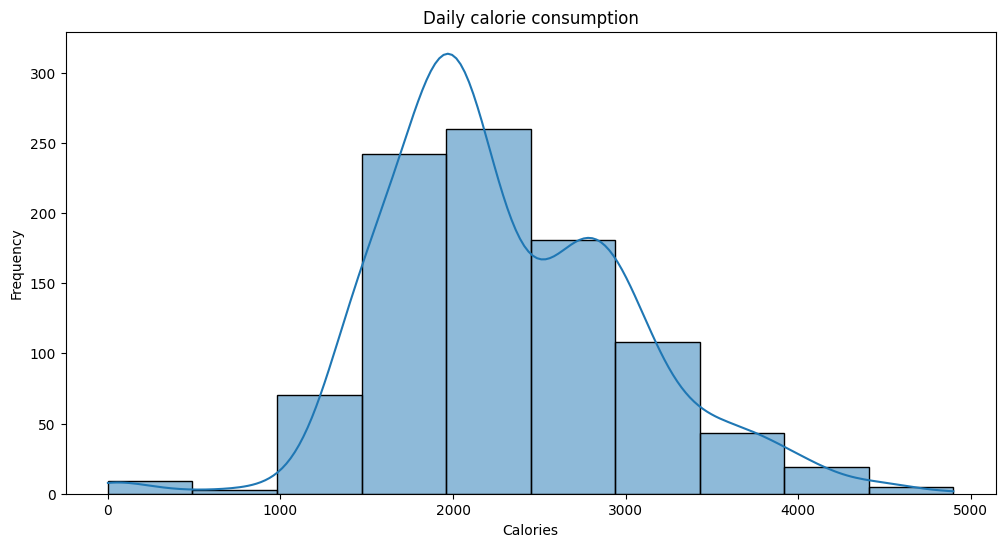

In [16]:
# Daily calorie intake
plt.figure(figsize=(12, 6))
sns.histplot(data=calories_df, x='Calories', bins=10, kde=True)
plt.title('Daily calorie consumption')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

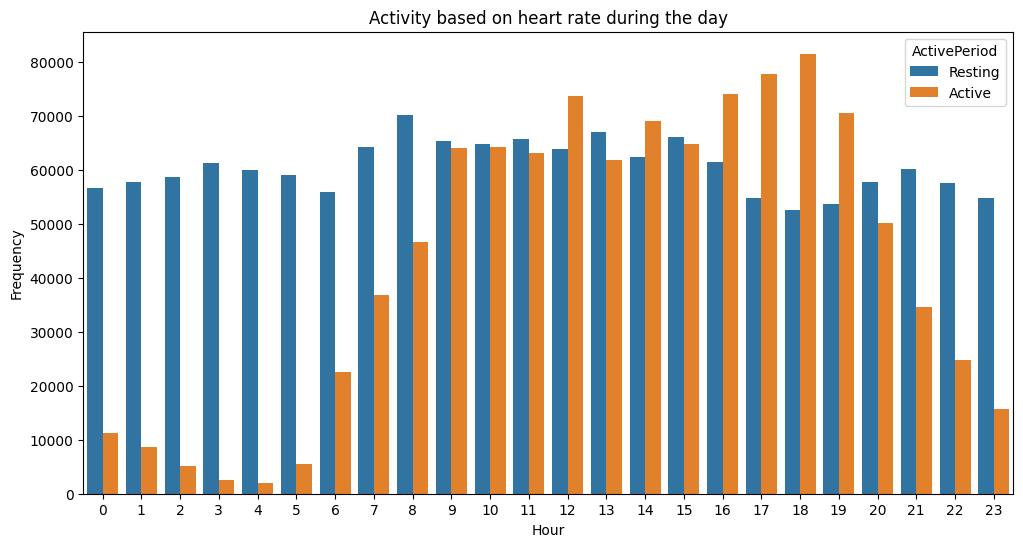

In [18]:
if 'hour' not in heart_rate_df.columns:
    heart_rate_df['time'] = pd.to_datetime(heart_rate_df['time'], format='%H:%M:%S')
    heart_rate_df['hour'] = heart_rate_df['time'].dt.hour

heart_rate_df['ActivePeriod'] = np.where(heart_rate_df['Value'] > heart_rate_df['Value'].mean(), 'Active', 'Resting')

hourly_int_df['ActiveHour'] = np.where(hourly_int_df['TotalIntensity'] > hourly_int_df['TotalIntensity'].mean(), 'High Activity', 'Low Activity')

plt.figure(figsize=(12, 6))
sns.countplot(data=heart_rate_df, x='hour', hue='ActivePeriod')
plt.title('Activity based on heart rate during the day')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

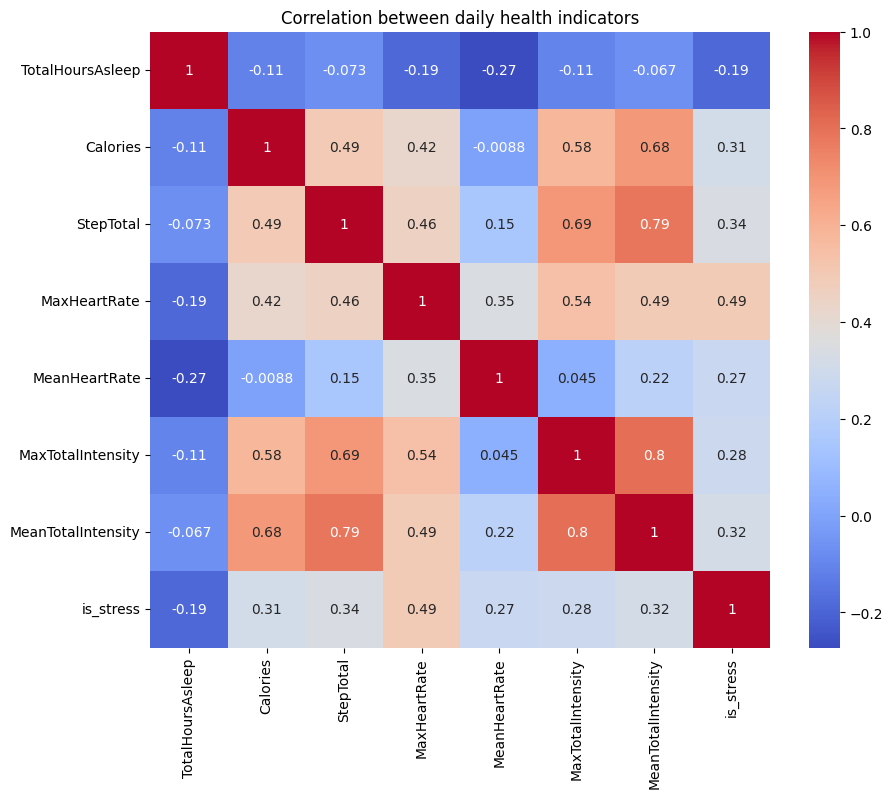

In [19]:
# Calculate correlation between daily values
daily_correlation_df = merged_df[['TotalHoursAsleep', 'Calories', 'StepTotal', 'MaxHeartRate', 'MeanHeartRate', 'MaxTotalIntensity', 'MeanTotalIntensity', 'is_stress']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(daily_correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation between daily health indicators')
plt.show()

In [20]:
# Split the data into train and test
X = merged_df[['MaxHeartRate', 'MeanHeartRate', 'TotalHoursAsleep', 'Calories', 'StepTotal', 'MaxTotalIntensity', 'MeanTotalIntensity']]
y = merged_df['is_stress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9636363636363636

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.60      0.75         5
         1.0       0.96      1.00      0.98        50

    accuracy                           0.96        55
   macro avg       0.98      0.80      0.87        55
weighted avg       0.97      0.96      0.96        55


Confusion Matrix:
 [[ 3  2]
 [ 0 50]]


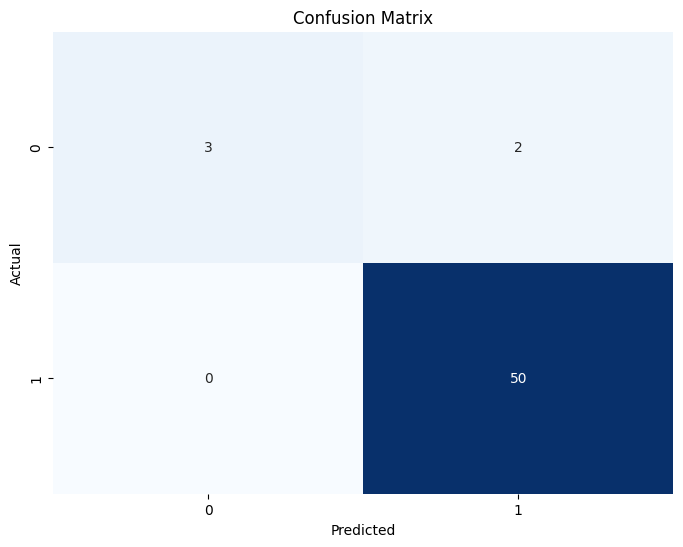

In [24]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<ipython-input-25-d968cc55bd81>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')


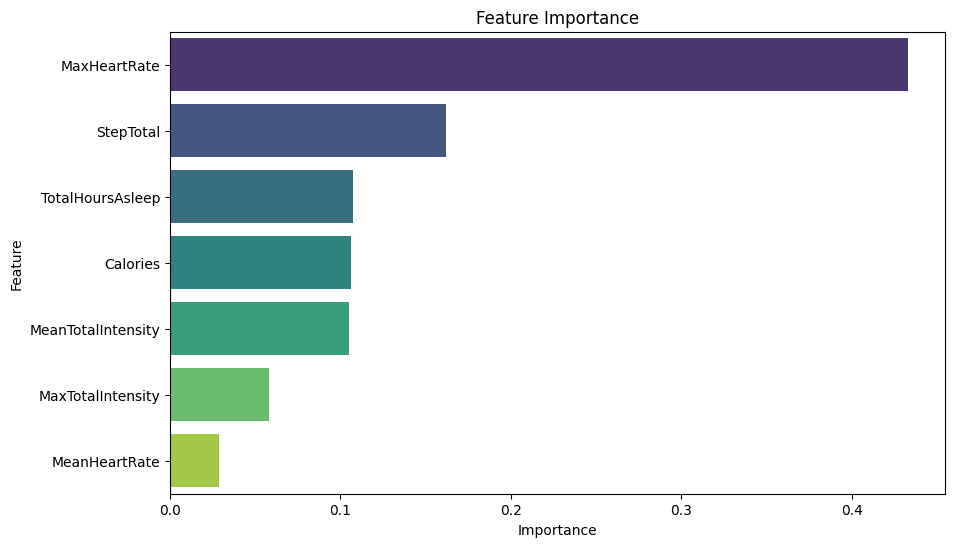

In [25]:
importances = model.feature_importances_
features = X.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [26]:
# Overview for a person
specific_id = 2347167796
specific_date = '2016-04-13'

person_day_data = merged_df[(merged_df['Id'] == specific_id) & (merged_df['date'] == specific_date)]

print("Data for ID:", specific_id, "and date:", specific_date)
print(person_day_data)

Data for ID: 2347167796 and date: 2016-04-13
             Id       date  MaxHeartRate  MeanHeartRate  is_stress  \
248  2347167796 2016-04-13         158.0      73.812905        1.0   

     TotalSleepRecords  TotalHoursAsleep  TotalHoursInBed  Calories  \
248                1.0              7.78             8.85      2038   

     StepTotal  ...  FairlyActiveHours  VeryActiveHours  \
248      10352  ...               0.53             0.32   

     SedentaryActiveDistance  LightActiveDistance  ModeratelyActiveDistance  \
248                      0.0                 3.41                      1.94   

     VeryActiveDistance  MaxTotalIntensity  MeanTotalIntensity  \
248                1.66               62.0           13.166667   

     MaxAverageIntensity  MeanAverageIntensity  
248             1.033333              0.219444  

[1 rows x 22 columns]


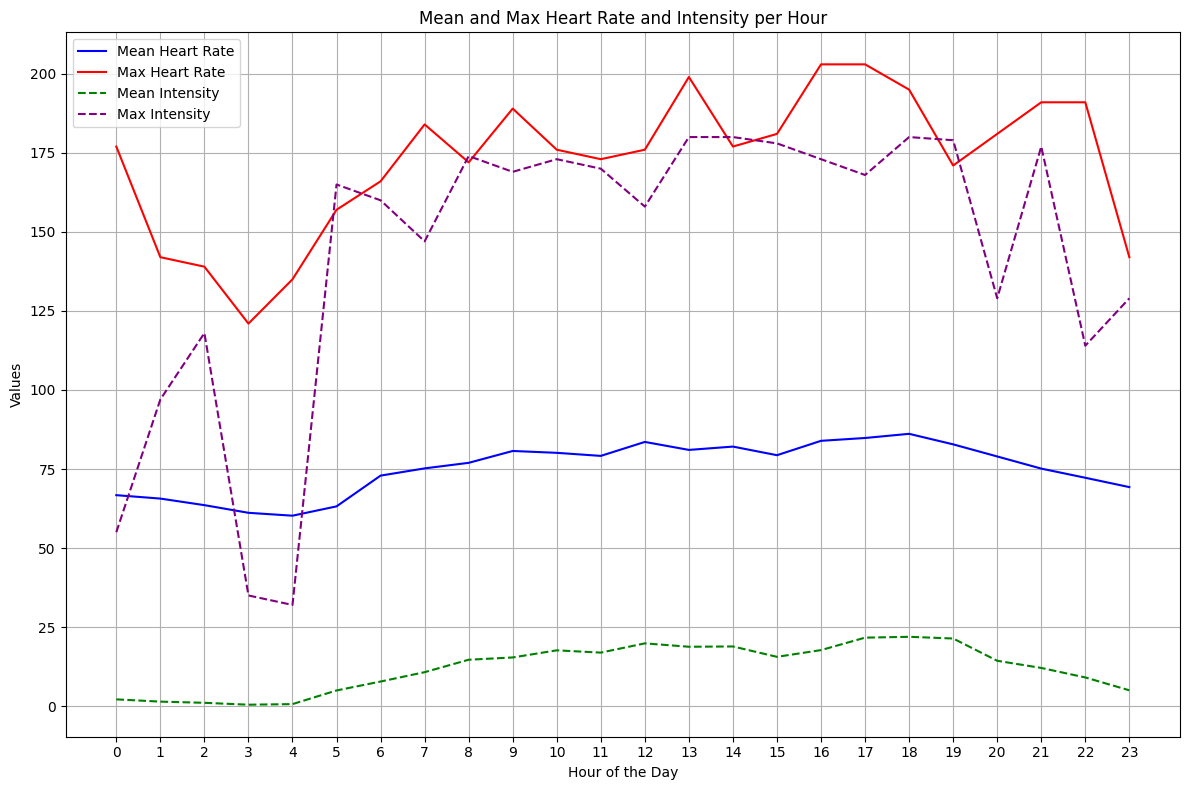

In [31]:
# Plot of heart rate and intensity during the day
heart_rate_df['time'] = pd.to_datetime(heart_rate_df['time'], format='%H:%M:%S')
heart_rate_df['hour'] = heart_rate_df['time'].dt.hour

hourly_avg_hr = heart_rate_df.groupby('hour')['Value'].mean().reset_index()
hourly_max_hr = heart_rate_df.groupby('hour')['Value'].max().reset_index()

hourly_int_df['time'] = pd.to_datetime(hourly_int_df['time'], format='%H:%M:%S')
hourly_int_df['hour'] = hourly_int_df['time'].dt.hour
hourly_avg_intensity = hourly_int_df.groupby('hour')['TotalIntensity'].mean().reset_index()
hourly_max_intensity = hourly_int_df.groupby('hour')['TotalIntensity'].max().reset_index()

hourly_stats = pd.merge(hourly_avg_hr, hourly_max_hr, on='hour', suffixes=('_avg_hr', '_max_hr'))
hourly_intensity = pd.merge(hourly_avg_intensity, hourly_max_intensity, on='hour', suffixes=('_avg_int', '_max_int'))
hourly_stats = pd.merge(hourly_stats, hourly_intensity, on='hour')

plt.figure(figsize=(12, 8))

sns.lineplot(data=hourly_stats, x='hour', y='Value_avg_hr', color='b', label='Mean Heart Rate')
sns.lineplot(data=hourly_stats, x='hour', y='Value_max_hr', color='r', label='Max Heart Rate')

sns.lineplot(data=hourly_stats, x='hour', y='TotalIntensity_avg_int', color='g', label='Mean Intensity', linestyle="--")
sns.lineplot(data=hourly_stats, x='hour', y='TotalIntensity_max_int', color='purple', label='Max Intensity', linestyle="--")

plt.title('Mean and Max Heart Rate and Intensity per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Values')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
drive.mount('/content/drive')
merged_df = pd.read_csv('/content/drive/My Drive/merged_data.csv')

Mounted at /content/drive


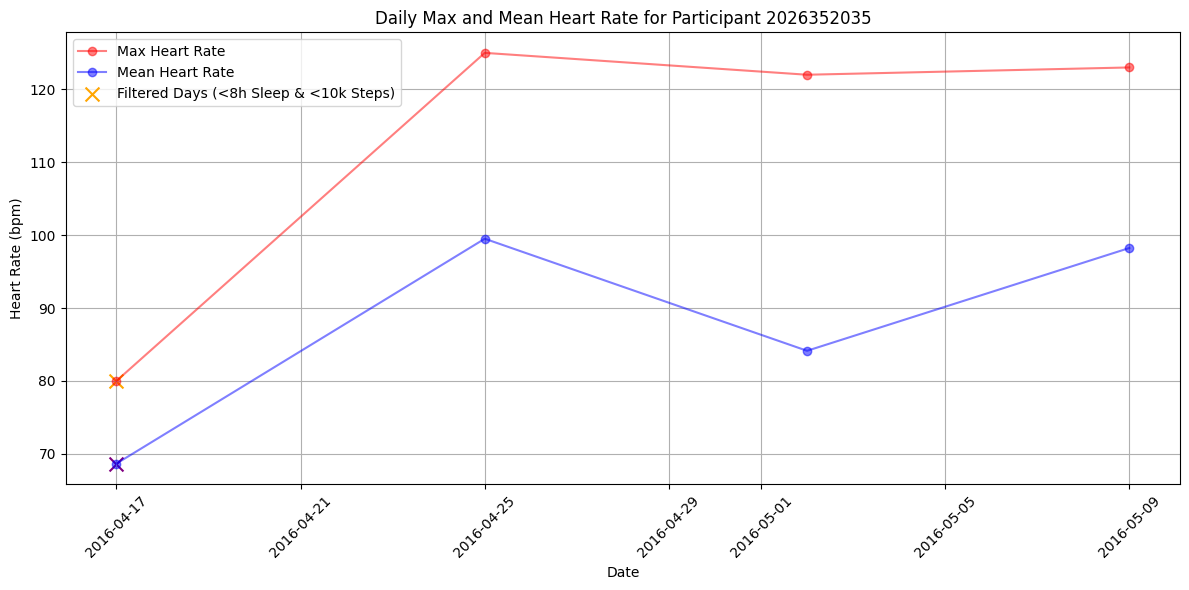

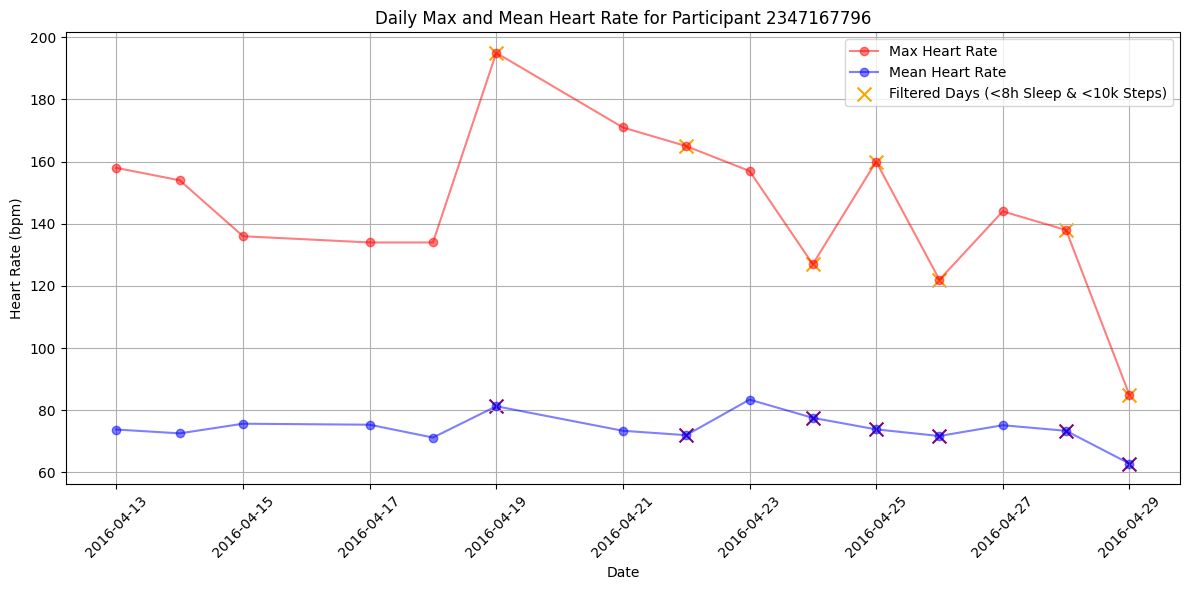

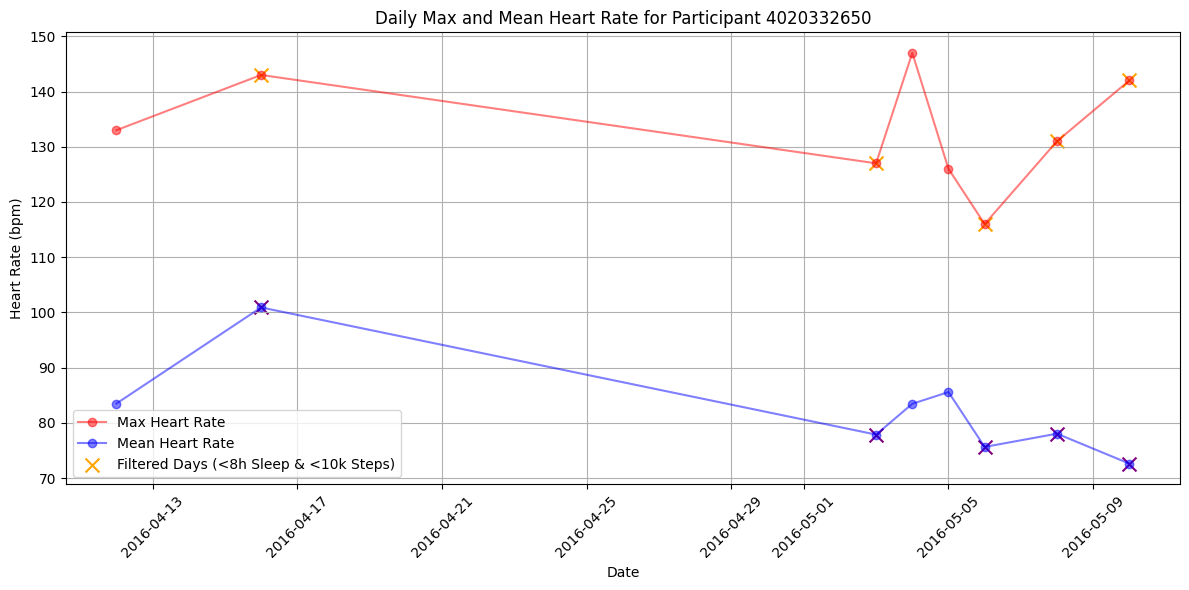

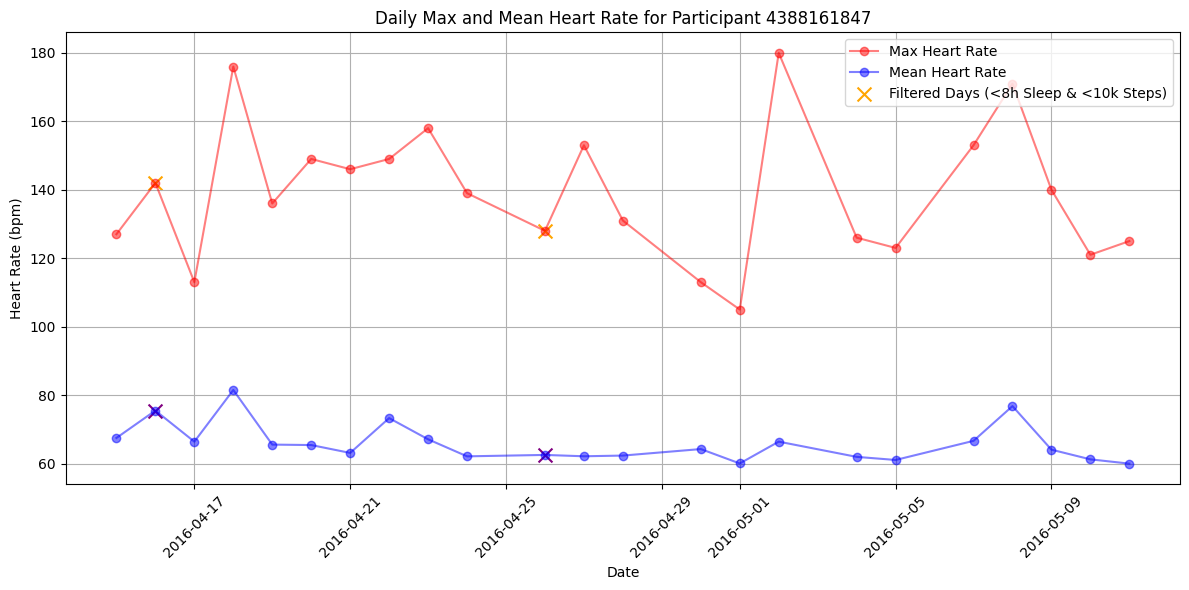

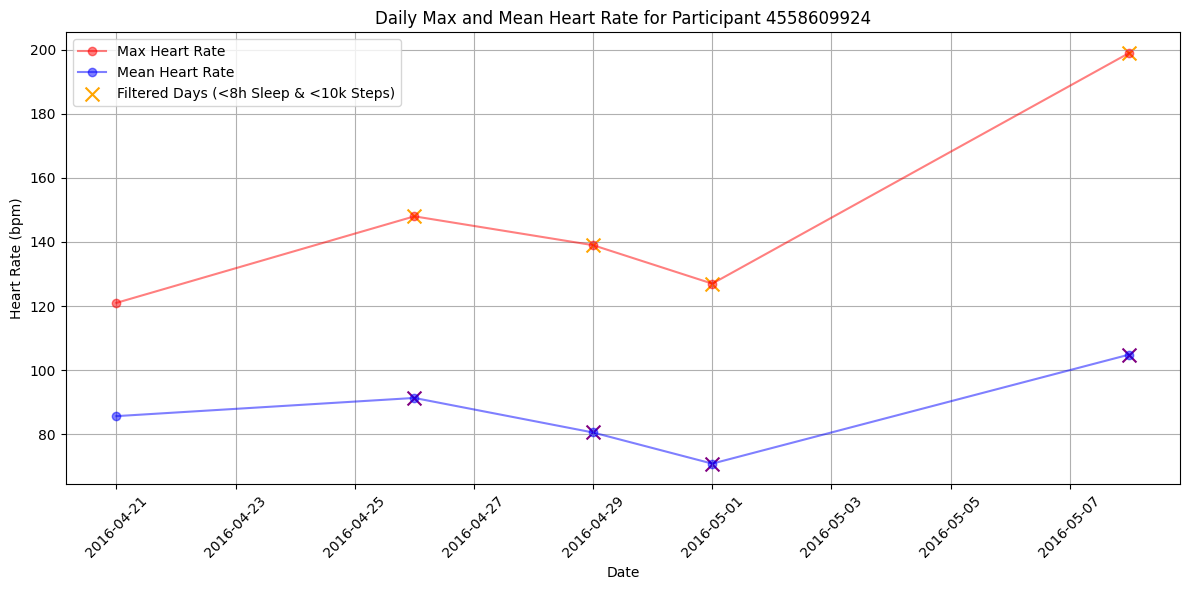

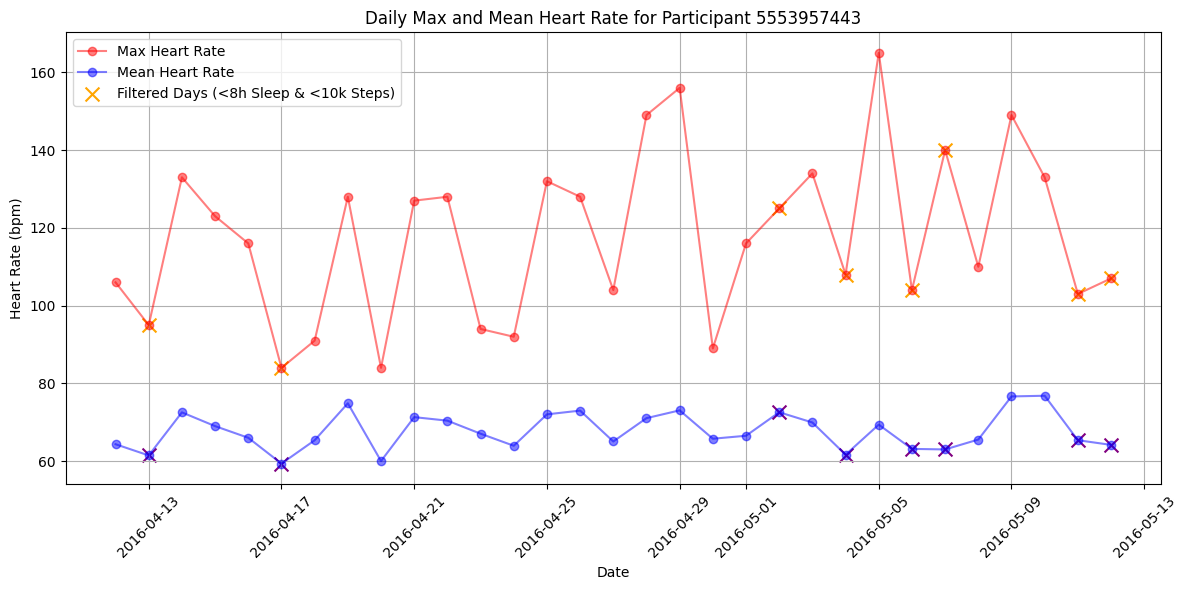

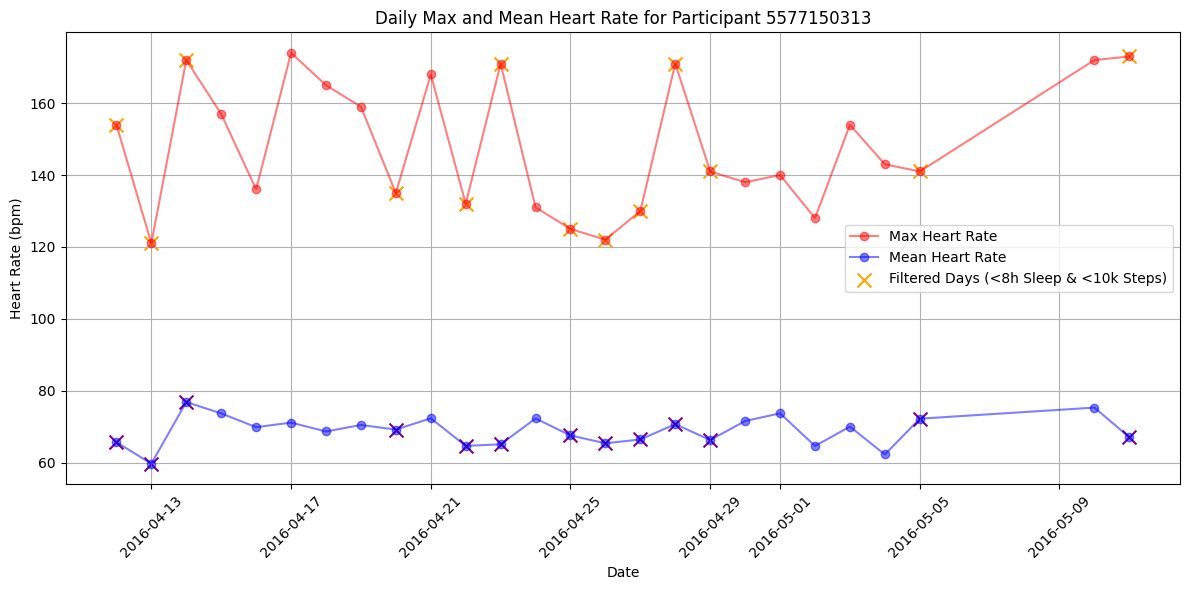

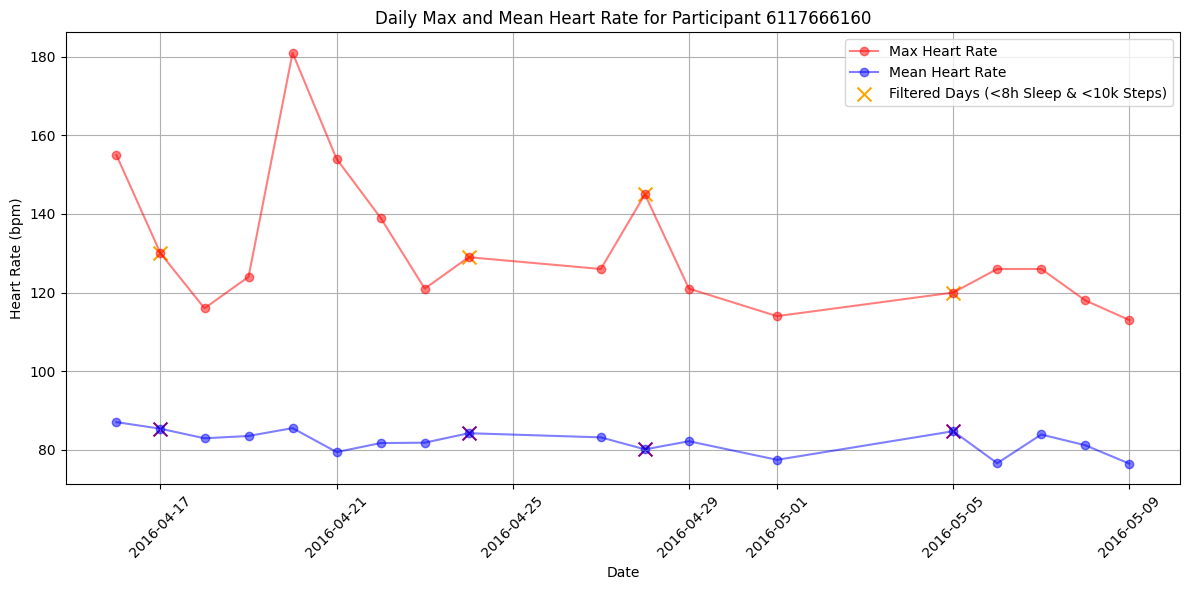

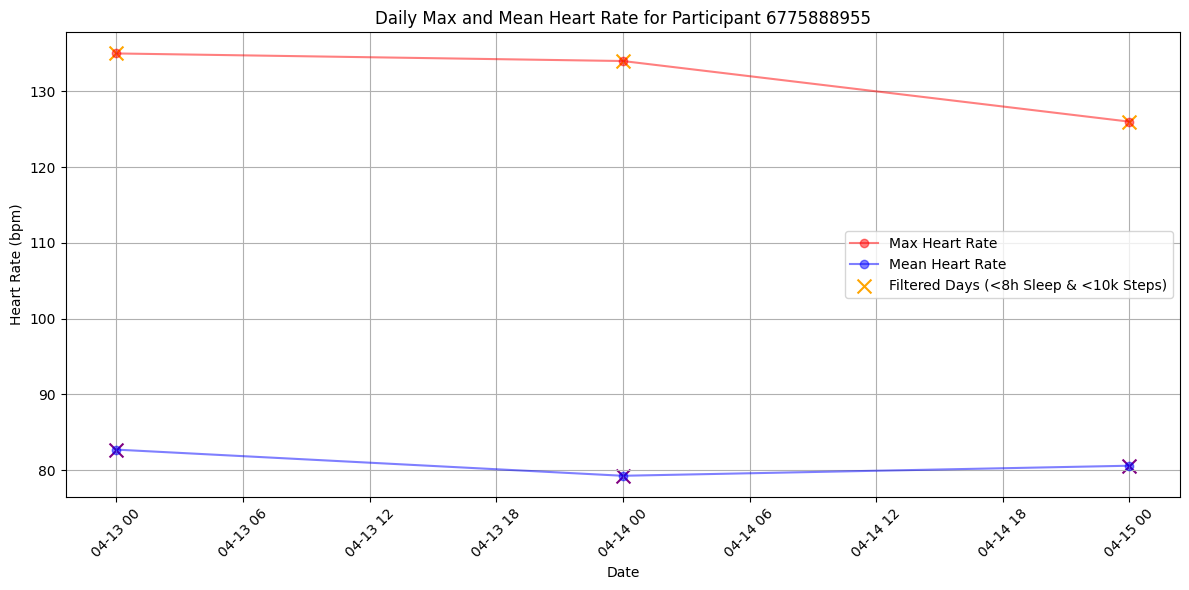

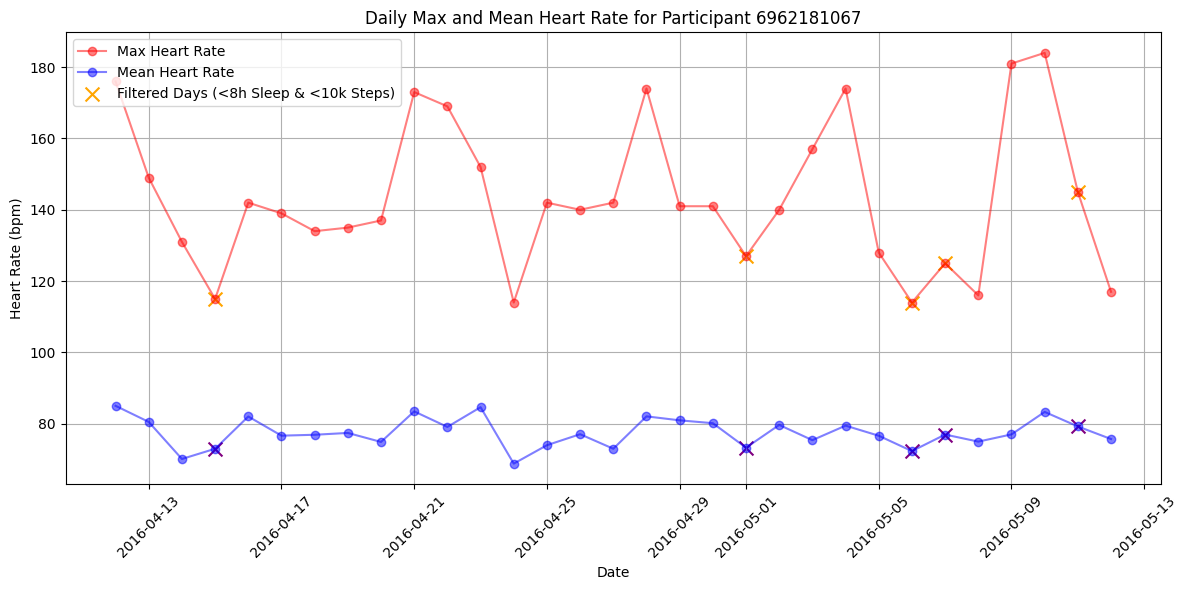

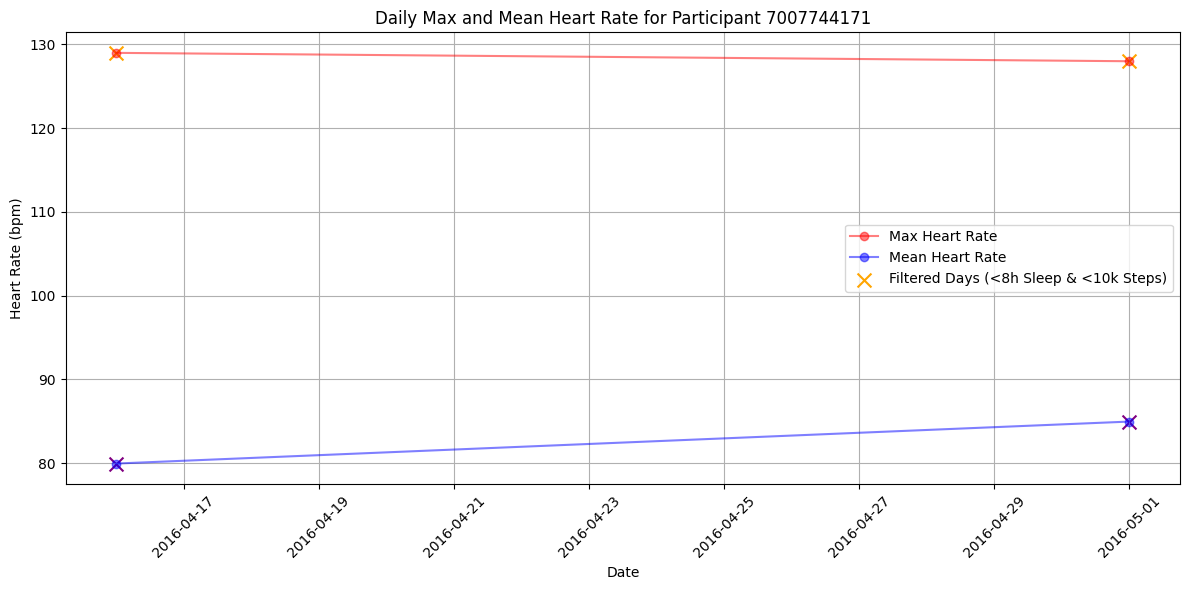

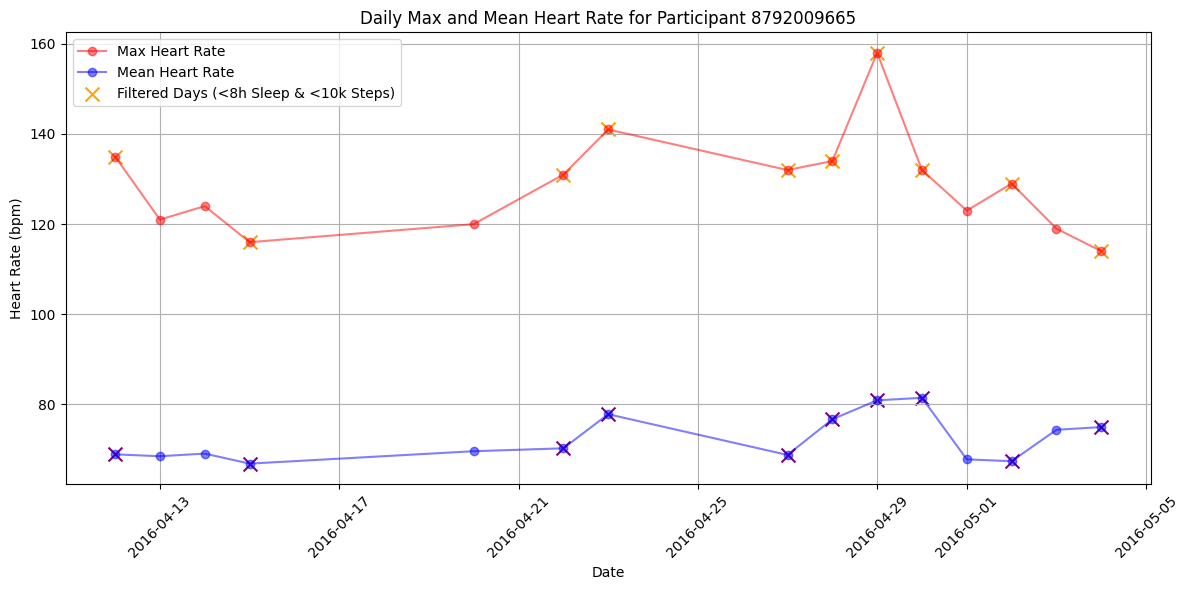

In [30]:
# Daily heart rate variability and stress visualization
for participant_id in merged_df['Id'].unique():
    participant_data = merged_df[merged_df['Id'] == participant_id]

    # Filter out days with low sleep (< 8 hours) and high steps (>= 10,000)
    filtered_data = participant_data[(participant_data['TotalHoursAsleep'] < 8) & (participant_data['StepTotal'] < 10000)]

    plt.figure(figsize=(12, 6))
    plt.plot(participant_data['date'], participant_data['MaxHeartRate'], label='Max Heart Rate', color='red', marker='o', alpha=0.5)
    plt.plot(participant_data['date'], participant_data['MeanHeartRate'], label='Mean Heart Rate', color='blue', marker='o', alpha=0.5)

    # Highlight filtered days
    plt.scatter(filtered_data['date'], filtered_data['MaxHeartRate'], color='orange', label='Filtered Days (<8h Sleep & <10k Steps)', marker='x', s=100)
    plt.scatter(filtered_data['date'], filtered_data['MeanHeartRate'], color='purple', marker='x', s=100)

    plt.legend()
    plt.title(f'Daily Max and Mean Heart Rate for Participant {participant_id}')
    plt.xlabel('Date')
    plt.ylabel('Heart Rate (bpm)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
